In [69]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_email, show_mail_graph, run_leiden
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
import numpy as np

%load_ext autoreload
%autoreload 2

# %pip install -r requirements.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
G = load_email(directed=False)

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Is Directed: {G.is_directed()}")

Nodes: 986
Edges: 16064
Is Directed: False


In [71]:
# show_mail_graph(G, k_core=5)

In [72]:
# Resolution = 1.0 is standard. Higher values > 1 lead to smaller communities.
louvain_communities = nx.community.louvain_communities(G, seed=42, resolution=3.0)

In [73]:
# Sort communities by size (largest first)
louvain_communities = sorted(louvain_communities, key=len, reverse=True)

In [74]:
print(f"Detected {len(louvain_communities)} communities.")
print(f"Sizes of the top 5 communities: {[len(c) for c in louvain_communities[:5]]}")

Detected 40 communities.
Sizes of the top 5 communities: [92, 86, 63, 60, 60]


In [75]:
# Modularity measures how well the graph divides into the found communities.
# For undirected graphs, Q ranges from -0.5 to 1. 
# Values > 0.3 often indicate good community structure.
modularity = nx.community.modularity(G, louvain_communities)
print(f"Modularity Score: {modularity:.4f}")

Modularity Score: 0.3508


In [76]:
# We need to align the Ground Truth (from file) with the Louvain Predictions (calculated)
ground_truth_dict = nx.get_node_attributes(G, 'ground_truth')
valid_nodes = list(G.nodes())
y_true = [ground_truth_dict[n] for n in valid_nodes]

In [77]:
# Create Prediction List aligned with G.nodes()
# Map every node to its assigned community ID (index in the list)
partition_map = {}
for idx, community_set in enumerate(louvain_communities):
    for node in community_set:
        partition_map[node] = idx

y_pred = [partition_map[n] for n in valid_nodes]

In [78]:
# Calculate Adjusted Rand Index (ARI)
# ARI = 0.0 means random labeling. ARI = 1.0 means perfect match.
ari_score = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index (ARI) vs Departments: {ari_score:.4f}")

Adjusted Rand Index (ARI) vs Departments: 0.5967



Visualizing the largest detected community (92 nodes)...


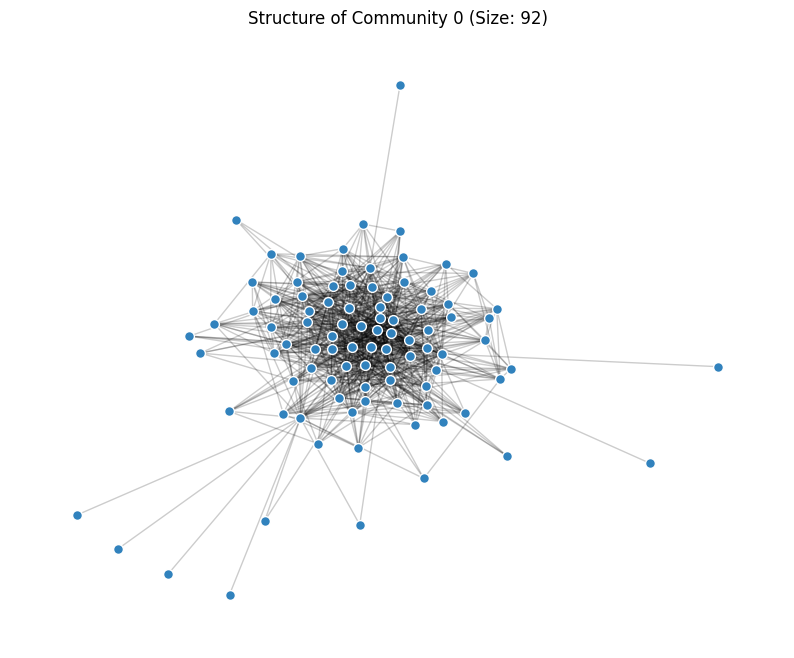

In [79]:
largest_comm = louvain_communities[0]
subgraph = G.subgraph(largest_comm)

print(f"\nVisualizing the largest detected community ({len(largest_comm)} nodes)...")
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42, k=0.15)

nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='#3182bd', edgecolors='white')
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)

plt.title(f"Structure of Community 0 (Size: {len(largest_comm)})")
plt.axis('off')
plt.show()

# Leiden

In [80]:
leiden_communities = run_leiden(G, resolution=3.0)

In [81]:
# Sort by size
leiden_communities = sorted(leiden_communities, key=len, reverse=True)
print(f"Leiden found {len(leiden_communities)} communities.")

Leiden found 40 communities.


In [82]:
ground_truth_dict = nx.get_node_attributes(G, 'ground_truth')
valid_nodes = list(G.nodes())
y_true = [ground_truth_dict[n] for n in valid_nodes]

# Build Prediction List
partition_map = {}
for idx, community_set in enumerate(leiden_communities):
    for node in community_set:
        partition_map[node] = idx
y_pred = [partition_map[n] for n in valid_nodes]

# Score
ari_score = adjusted_rand_score(y_true, y_pred)
print(f"Leiden Adjusted Rand Index (ARI): {ari_score:.4f}")

Leiden Adjusted Rand Index (ARI): 0.6006



Visualizing largest Leiden community (99 nodes)...


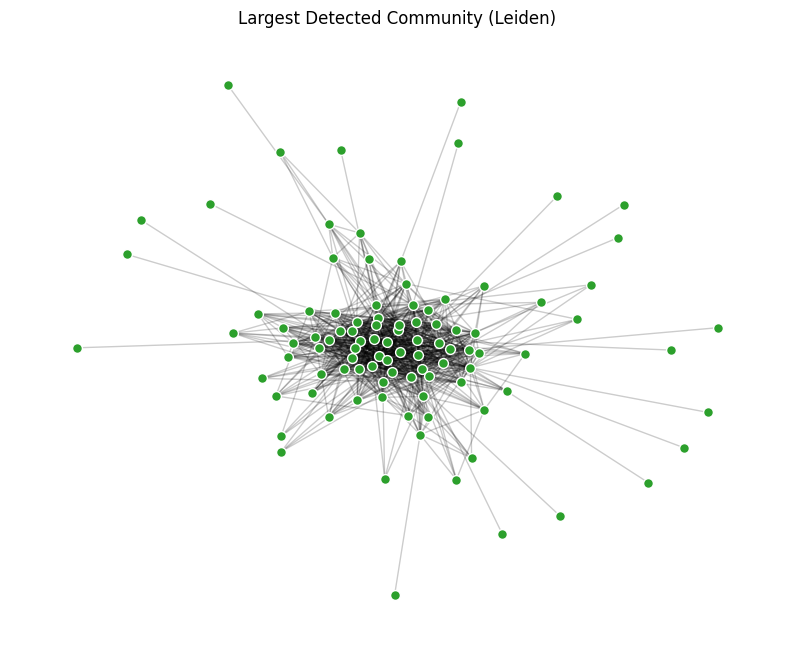

In [83]:
largest_comm = leiden_communities[0]
subgraph = G.subgraph(largest_comm)

print(f"\nVisualizing largest Leiden community ({len(largest_comm)} nodes)...")
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42, k=0.15)
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='#2ca02c', edgecolors='white') # Green for Leiden
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
plt.title("Largest Detected Community (Leiden)")
plt.axis('off')
plt.show()

In [84]:
G = load_email(directed=False)
# Adjacency Matrix, compressed sparse row format (to fit sklearn requirements)
adj_matrix = nx.to_scipy_sparse_array(G, format='csr')
adj_matrix.indices = adj_matrix.indices.astype(np.int32)
adj_matrix.indptr = adj_matrix.indptr.astype(np.int32)

In [85]:
# We must define n_clusters. 
# Since we have the labels, let's use the actual number of departments (42).
sc = SpectralClustering(
    n_clusters=42, 
    affinity='precomputed', 
    n_init=10, 
    assign_labels='discretize',
    random_state=42
)
labels = sc.fit_predict(adj_matrix)

In [86]:
# adjacency matrix is ordered by G.nodes(), so the labels match that order
nodes = list(G.nodes())
y_pred = labels
# GT
ground_truth_dict = nx.get_node_attributes(G, 'ground_truth')
y_true = [ground_truth_dict[n] for n in nodes]

In [87]:
# Score
ari_score = adjusted_rand_score(y_true, y_pred)
print(f"Spectral Clustering (k=42) ARI: {ari_score:.4f}")

Spectral Clustering (k=42) ARI: 0.4301
